In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle

import numpy as np
#from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import LambdaCDM
cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo = cosmoLambdaCDM

from astropy.cosmology import Planck18

from scipy.integrate import quad, dblquad
from scipy.stats import gengamma, rayleigh

from numba import njit, jit
from ler.utils import rejection_sample, create_inv_cdf
from scipy.interpolate import interp1d

In [11]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation(z_max=40, cosmology=cosmoLambdaCDM,) 

NameError: name 'cosmoLambdaCDM' is not defined

In [7]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

In [8]:
@jit
def cross_section_SIS(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@njit
def phi_cut_SIE(q):
    n = len(q)
    result = np.empty(n)
    for i in range(n):
        val = q[i]
        if 0.01 < val < 0.99:
            result[i] = (2 * np.pi * val * np.log(val)) / (val ** 2 - 1)
        elif val < 0.01:
            result[i] = -2 * (np.pi * np.log(val)) * val
        else:
            result[i] = np.pi
    return result/np.pi

## 0. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[0,600]$
* Oguri style

In [9]:
sigma_pdf_SIE0 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIE0 = quad(sigma_pdf_SIE0, 1, 600)[0]
sigma_pdf_SIE0 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIE0

def sample_sigma_q_SIE0(sigma_lim=[1,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE0, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE0(zl, zs):
    sigma, q = sample_sigma_q_SIE0(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE0(zs):
    result = quad(integrand_SIE0, 0, zs, args=(zs))

    return result[0]

In [18]:
optical_depth_SIE0(1.5)

0.0009415644478379556

## 1. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Oguri style

In [19]:

sigma_pdf_SIE1 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIE1 = quad(sigma_pdf_SIE1, 60, 600)[0]
sigma_pdf_SIE1 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIE1

def sample_sigma_q_SIE1(sigma_lim=[60,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE1(zl, zs):
    sigma, q = sample_sigma_q_SIE1(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE1(zs):
    result = quad(integrand_SIE1, 0, zs, args=(zs))

    return result[0]

## 2. SIE

* $\sigma_v$ dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* normalization of $z$ in the range $[0,3]$
* Oguri style

In [20]:
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
sigma_pdf_norm_SIE2 = dblquad(sigma_pdf_SIE2, 0, 3, 60, 600)[0]
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)/sigma_pdf_norm_SIE2

def sample_sigma_q_SIE2(zl, sigma_lim=[60,600], size=200):

    sigma = test.conditional_rejection_sample(sigma_pdf_SIE2,sigma_lim[0],sigma_lim[1],zl,size=size,chunk_size=1000)
    
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q

def integrand_SIE2(zl, zs):
    sigma, q = sample_sigma_q_SIE2(zl,size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIE2(zs):
    result = quad(integrand_SIE2, 0, zs, args=(zs))

    return result[0]

## 3. SIS

* $\sigma_v$ independent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Haris style

In [21]:
# normalised pdf
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS1 = quad(sigma_pdf_SIS1, 60, 600)[0]
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS1

def sample_sigma_SIS1(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS1(zl, zs):
    sigma = sample_sigma_SIS1(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS1(zs):
    result = quad(integrand_SIS1, 0, zs, args=(zs))

    return result[0]

In [22]:
optical_depth_SIS1(1.5)

0.0003888592571569639

In [23]:
# normalised pdf
sigma_pdf_SI = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIE1 = quad(sigma_pdf_SIE1, 60, 600)[0]
sigma_pdf_SIE1 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIE1

sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)
sigma_pdf_norm_SIS2 = quad(sigma_pdf_SIS2, 60, 600)[0]
sigma_pdf_SIS2 = lambda sig_: sig_**4*test.philocbernardi(sig_)/sigma_pdf_norm_SIS2

def sample_sigma_SIS2(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS2, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS2(zl, zs):
    sigma = sample_sigma_SIS2(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS2(zs):
    result = quad(integrand_SIS2, 0, zs, args=(zs))

    return result[0]

In [24]:
optical_depth_SIS2(1.5)

0.00099262071459667

In [4]:
def strong_lensing_optical_depth_SIS(zs):
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return 4.17*1e-6*(Dc) ** 3

strong_lensing_optical_depth_SIS(zs=1.5)

0.0003465350907932671

* normalization matters

### Velcity dispersion comparision

In [26]:
sigma1, q1 = sample_sigma_q_SIE1(size=1000)

In [27]:
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=1000)

In [30]:
sigma3 = sample_sigma_SIS1(sigma_lim=[60,600], size=200)

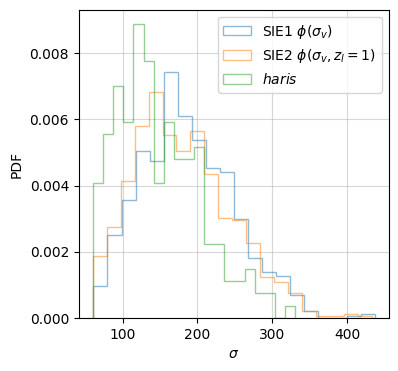

In [31]:
# all three models are normalised, sigma->[60,600]
# plot comparison
plt.figure(figsize=(4,4))
plt.hist(sigma1, bins=20, alpha=0.5, label=r'SIE1 $\phi(\sigma_v)$', density=True, histtype='step')
plt.hist(sigma2, bins=20, alpha=0.5, label=r'SIE2 $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')
plt.hist(sigma3, bins=20, alpha=0.5, label=r'$haris$', density=True, histtype='step')
plt.xlabel(r'$\sigma$')
plt.ylabel('PDF')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* gamma distribution taken by Haris is different as compare to Oguri

### Optical depth comparision

In [181]:
zs = np.linspace(0.001, 2, 10)
tau_sie1 = np.array([optical_depth_SIE1(zs=z) for z in zs])

In [182]:
# takes 2m 58s for 10 zs
zs = np.linspace(0.001, 2, 10)
tau_sie2 = np.array([optical_depth_SIE2(zs=z) for z in zs])

In [183]:
zs = np.linspace(0.001, 2, 10)
tau_sis1 = np.array([optical_depth_SIS1(zs=z) for z in zs])


In [184]:
zs = np.linspace(0.001, 2, 10)
tau_sis2 = np.array([optical_depth_SIS2(zs=z) for z in zs])

In [185]:
zs = np.linspace(0.001, 2, 10)
tau_haris = strong_lensing_optical_depth_SIS(zs)

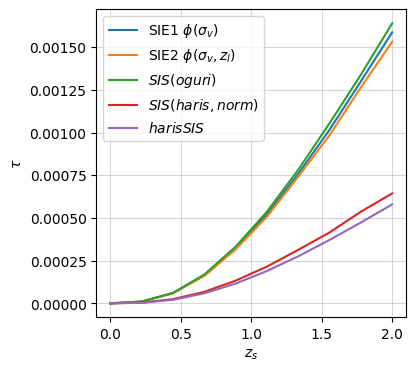

In [187]:
# plot
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sie1, label=r'SIE1 $\phi(\sigma_v)$')
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')
plt.plot(zs, tau_sis2, label=r'$SIS (oguri)$')
plt.plot(zs, tau_sis1, label=r'$SIS (haris, norm)$')
plt.plot(zs, tau_haris, label=r'$haris SIS$')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Conclusion

| Model | Lens Model | $\sigma_v$ Dependency on $z$ | Normalization of $\sigma_v$ | Normalization of $z$ | Sigma Cut Dependency | Gamma Distribution Source |
|-------|------------|-------------------------------|-----------------------------|----------------------|----------------------|---------------------------|
| 1     | SIE        | No                           | [60, 600]                   | None                 | Mass Ratio           | Oguri                    |
| 2     | SIE        | Yes                          | [60, 600]                   | [0, 3]               | Mass Ratio           | Oguri                    |
| 3     | SIS        | No                           | [60, 600]                   | None               | Mass Ratio           | Oguri                    |
| 4     | SIS        | No                           | [60, 600]                   | None                 | None                 | Haris                    |
| 5     | SIS        | No                           | None                        | None                 | None                 | Haris                    |



* The difference mainly comes from the velocity dispersion distribution shape and also the normalization
* The difference between the model1/2/3 is not very large.
* Between model4 and model5, the difference is significant, which means the normalization of velocity dispersion is important.

## Check for $z_l$ distribution  

* fixed $\sigma_v=161 km/s$ 

In [224]:
# use interpolation to find the pdf of zl
def zl_pdf_SIE(zl_list, zs=5, sigma=161):
    sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
    zl = np.linspace(0.001, zs, 100)
    sigma = np.ones(len(zl))*sigma
    zl_pdf_unnorm = interp1d(zl, sigma_pdf_SIE2(sigma,zl), kind='cubic')
    zl_norm = quad(zl_pdf_unnorm, 0.001, zs)[0]

    return zl_pdf_unnorm(zl_list)/zl_norm

In [220]:
zl_lens = lens.sample_lens_redshifts(np.ones(1000)*2)

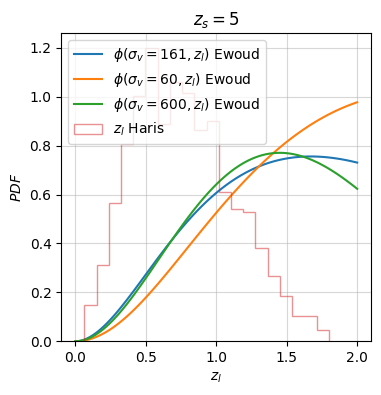

In [227]:
# plot
zl = np.linspace(0.001, 2, 100)
plt.figure(figsize=(4,4))
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=161), label=r'$\phi(\sigma_v=161,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=60), label=r'$\phi(\sigma_v=60,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=600), label=r'$\phi(\sigma_v=600,z_l)$ Ewoud')
plt.hist(zl_lens, bins=20, alpha=0.5, label=r'$z_l$ Haris', density=True, histtype='step')
plt.title(r'$z_s=5$')
plt.xlabel(r'$z_l$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* Haris and Oguri style is different

## Validation of the interpolation method of sigma sampling

In [2]:
import test2
#reload(test)
import importlib
importlib.reload(test2)

<module 'test2' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test2.py'>

In [3]:
vd = test2.VelocityDispersionSampler()

Inveverse CDF of Velocity dispersion for inverse transform sampling will be loaded from ./interpolator_pickle/vel_disp/inv_cdf_0.pickle


In [ ]:
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')

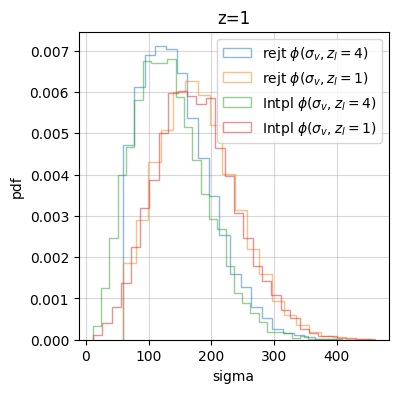

In [45]:
# plot velo disp
plt.figure(figsize=(4,4))

sigma2, q2 = sample_sigma_q_SIE2(zl=4, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=4)$', density=True, histtype='step')
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')

sample = vd.sample_vel_disp(4, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=4)$')
sample = vd.sample_vel_disp(1.0, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=1)$')

plt.xlabel('sigma')
plt.ylabel('pdf')
plt.title('z=1')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* It's perfect 

In [1]:
# plot optical depth with zl pdf

def optical_depth_SIS(self, zs):
    """
    Function to compute the strong lensing optical depth (SIS)

    Parameters
    ----------
        zs : `float`
            source redshifts

    Returns
    -------
        tau : `float`
            strong lensing optical depth

    """
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = lens.z_to_Dc(zs) * 1e-3  # 1e-3 converts Mpc to Gpc

    return (Dc / 62.2) ** 3

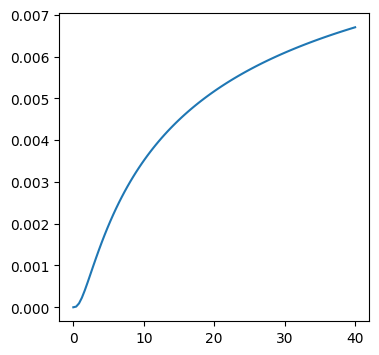

In [6]:
# plot optical depth with zl pdf (sis only)
plt.figure(figsize=(4,4))
zs = np.linspace(0.001, 40, 100)
tau = strong_lensing_optical_depth_SIS(zs)
plt.plot(zs, tau, label=r'$\tau$ SIS')
plt.show()


In [ ]:

        if lens_type == "epl_galaxy":
            sampler_priors_ = dict(
                source_parameters="sample_strongly_lensed_source_parameters",
                lens_redshift="lens_redshift_SDSS_catalogue",
                velocity_dispersion="velocity_dispersion_gengamma",
                axis_ratio="axis_ratio_rayleigh",
                axis_rotation_angle="axis_rotation_angle_uniform",
                shear="shear_norm",
                mass_density_spectral_index="mass_density_spectral_index_normal",
            )
            sampler_priors_params_ = dict(
                source_parameters=None,
                lens_redshift=dict(zs=self.lens_parameters["zs"]),
                velocity_dispersion=dict(a=2.32 / 2.67, c=2.67),
                axis_ratio=dict(sigma=self.lens_parameters["sigma"]),
                axis_rotation_angle=dict(phi_min=0.0, phi_max=2 * np.pi),
                shear=dict(scale=0.05),
                mass_density_spectral_index=dict(mean=2.0, std=0.2),
            )
        else:
            raise ValueError("lens_type not recognized")
        
        # update the priors if input is given
        if sampler_priors:
            sampler_priors_.update(sampler_priors)
        if sampler_priors_params:
            sampler_priors_params_.update(sampler_priors_params)

        # dict of sampler names with description
        lens_sampler_names_ = dict(
            sample_source_parameters="source parameters conditioned on the source being strongly lensed",
            sample_lens_redshift="lens redshift",
            sample_velocity_dispersion="velocity dispersion of elliptical galaxy",
            sample_axis_ratio="axis ratio of elliptical galaxy",
            sample_axis_rotation_angle="axis rotation angle of elliptical galaxy    ",
            sample_shear="shear of elliptical galaxy",
            sample_mass_density_spectral_index="mass density spectral index of elliptical power-law galaxy",
        )

In [1]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation() 

In [2]:
lens.sample_all_routine2(size=10)

KeyError: 'axis_rotation_angle'

In [3]:
lens.lens_parameters

{'zs': array([5.76228904, 3.07214191, 7.44341903, 2.59705703, 9.64962964,
        6.69236342, 6.41149416, 4.90056582, 2.45333903, 2.037457  ]),
 'geocent_time': array([1.24404041e+09, 1.25707870e+09, 1.25089120e+09, 1.26444952e+09,
        1.24474893e+09, 1.25304751e+09, 1.24924307e+09, 1.26120754e+09,
        1.25439616e+09, 1.24981748e+09]),
 'phase': array([1.0951605 , 3.57569709, 3.47080089, 0.44898187, 4.00404309,
        5.87879035, 0.4845016 , 6.07202856, 0.92249716, 3.80274203]),
 'psi': array([2.07299066, 2.08122855, 3.06164298, 0.58459575, 1.87037547,
        0.40940696, 1.25314308, 2.00907426, 2.65388381, 1.89831711]),
 'theta_jn': array([1.03789892, 1.85919606, 2.46228514, 0.6025081 , 0.8657958 ,
        2.75644033, 1.6874888 , 2.73655232, 1.23182352, 1.91195486]),
 'luminosity_distance': array([ 56268.36967066,  26768.19639092,  75658.11160124,  21868.74480198,
        101792.29423455,  66928.93702048,  63690.95737795,  46568.39954564,
         20413.91383271,  16289.12706

In [6]:
lens.lens_redshift_SDSS_catalogue(size=10, param=dict(sampled_zs=True))

array([1.02738178, 0.36823624, 0.46698443, 0.53215766, 0.42409801,
       2.60809736, 0.92081391, 1.72801175, 1.76683408, 0.57289116])

In [3]:
lens.lens_redshift_SDSS_catalogue(size=10, sampled_zs=True)

zs is not given, using the sampled zs from self.lens_parameters


array([0.80993728, 1.286315  , 1.59445812, 0.3251686 , 0.75319419,
       2.46195531, 1.85172638, 0.33475898, 1.76413515, 0.99189987])

In [4]:
lens.lens_redshift_SDSS_catalogue(size=10,)

zs is not given, using the sampled zs from self.lens_parameters


array([1.02444368, 1.42994427, 1.0090794 , 0.76117542, 1.87745486,
       1.21852119, 1.21548344, 1.31959765, 2.73829418, 0.32260589])

In [6]:
size = 10
param_names = list(lens.lens_param_samplers.keys())
samplers_params = list(lens.lens_param_samplers_params.values())
# make sure the order is correct
sampler_names = list(lens.lens_sampler_names.keys())
param_dict = lens.lens_parameters  # initialize dictionary to store parameters

In [3]:
lens.lens_parameters

{'zs': array([7.54615787, 5.18262121, 2.55092719, 3.47030168, 3.99838299,
        2.28740968, 3.55448658, 3.26325724, 4.72025057, 2.57076223]),
 'sigma': None,
 'geocent_time': array([1.26384844e+09, 1.25545627e+09, 1.26163163e+09, 1.26538806e+09,
        1.24460044e+09, 1.26746993e+09, 1.24869695e+09, 1.26488127e+09,
        1.26594348e+09, 1.26184109e+09]),
 'sky_position': (array([2.80971257, 2.30388505, 3.63488241, 2.12003397, 2.07491488,
         2.75429933, 4.21311087, 2.21880793, 2.78493757, 5.08626705]),
  array([-0.67532634, -0.95435544,  0.35303909, -0.81502617, -1.15550771,
         -0.49003819, -0.5022504 , -1.3923231 , -1.22163195, -0.73136549])),
 'phase': array([5.05389295, 2.34577566, 5.60134855, 2.87914007, 5.17694158,
        2.83714152, 2.81045099, 3.12720181, 2.90605954, 2.72801632]),
 'psi': array([2.17580482, 1.36110617, 2.80878494, 0.17031404, 1.01173399,
        3.04416995, 0.86916969, 1.11132436, 1.9689599 , 2.60327669]),
 'theta_jn': array([1.7039636 , 1.54732

In [ ]:
# sample source parameters first (conditioned on the source being strongly lensed)
source_params_strongly_lensed = getattr(lens, sampler_names[0])(size=size, param=samplers_params[0])
param_dict.update(source_params_strongly_lensed)
del param_names[0], sampler_names[0], samplers_params[0]  # remove source parameters from the list

In [7]:
from ler.gw_source_population import SourceGalaxyPopulationModel

cbc = SourceGalaxyPopulationModel()

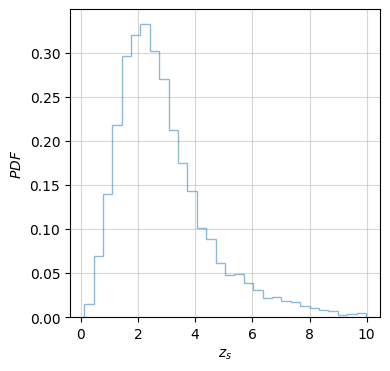

In [14]:
zs = cbc.sample_redshift_of_source(10000)
# plot hist
plt.figure(figsize=(4,4))
plt.hist(zs, bins=30, alpha=0.5, density=True, histtype='step')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.show()

In [15]:
from ler.gw_source_population import CompactBinaryPopulation

cbc = CompactBinaryPopulation()

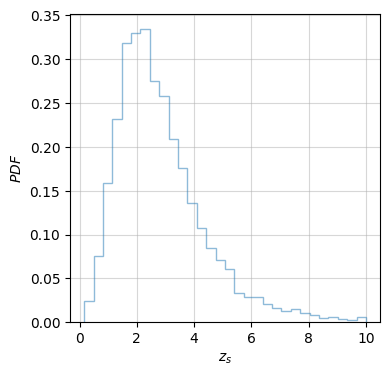

In [16]:
zs = cbc.sample_source_redshifts(10000)
# plot hist
plt.figure(figsize=(4,4))
plt.hist(zs, bins=30, alpha=0.5, density=True, histtype='step')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.show()

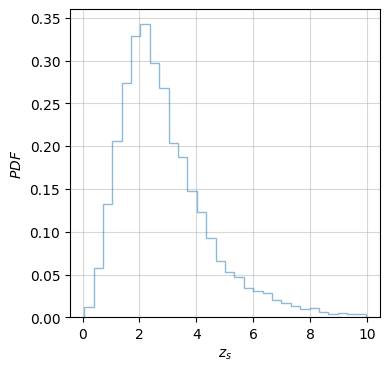

In [17]:
zs = cbc.sample_redshift_of_source(10000)
# plot hist
plt.figure(figsize=(4,4))
plt.hist(zs, bins=30, alpha=0.5, density=True, histtype='step')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.show()

In [10]:
1/723*100

0.25